In [60]:
_get_molecule_sasa_fft(com_grid, complex, 0.14, 960).sum()

62.464767

In [ ]:
compare_coordinates_with_diff(complex.xyz[0], com_grid._crd/10.)

In [1]:
def average_distance(coordinates):
    total_distance = 0
    total_pairs = 0
    
    # Iterate through each coordinate pair
    for i in range(len(coordinates)):
        for j in range(i+1, len(coordinates)):
            # Calculate distance between points
            distance = math.sqrt(sum((a - b) ** 2 for a, b in zip(coordinates[i], coordinates[j])))
            total_distance += distance
            total_pairs += 1
    
    # Calculate average distance
    if total_pairs > 0:
        avg_distance = total_distance / total_pairs
        return avg_distance
    else:
        return 0

In [68]:
average_distance(complex.xyz[0])

1.8810086077051094

In [69]:
average_distance(com_grid._crd/10.)

1.8392805623930593

In [1]:
import mdtraj as md
import bpmfwfft.grids as grids
import numpy as np

In [2]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/media/jim/Research_TWO/FFT_PPI'
    home = '/home/jim'
else:
    ppi_path = '/mnt/elpis/jtufts/fft/FFT_PPI_1_0'
    home = '/home/jtufts'

In [3]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if filenames[0] != 'run_me.sh':
        if 'complex.pdb' in filenames:
            f[dirpath.split('/')[8]] = dirpath + '/complex.pdb'

In [4]:
keys = list(f.keys())
keys.sort()
system = keys[127] #36 
system

'2OOB_A:B'

In [5]:
%%time
import netCDF4 as nc
import numpy as np
# grid_name = "sasa1.nc"
grid_name = "grid.nc"
grid_path = f'{ppi_path}/2.redock/4.receptor_grid/{system}'
print(grid_path)
grid_nc = '%s/%s'%(grid_path,grid_name)


#parsing some of the netcdf variables from grid.nc
grid_variables = nc.Dataset(grid_nc, 'r').variables
counts = nc.Dataset(grid_nc, 'r').variables["counts"][:]
x = nc.Dataset(grid_nc, 'r').variables["x"][:]
y = nc.Dataset(grid_nc, 'r').variables["y"][:]
z = nc.Dataset(grid_nc, 'r').variables["z"][:]
# electrostatic = nc.Dataset(grid_nc, 'r').variables["electrostatic"][:]
# lja = nc.Dataset(grid_nc, 'r').variables["LJa"][:]
# ljr = nc.Dataset(grid_nc, 'r').variables["LJr"][:]
sasa = nc.Dataset(grid_nc, 'r').variables["sasa"][:]
occupancy = nc.Dataset(grid_nc, 'r').variables["occupancy"][:]
trans_crd = nc.Dataset(grid_nc, 'r').variables["trans_crd"][:]
rec_disp = nc.Dataset(grid_nc, 'r').variables["displacement"][:]
water = nc.Dataset(grid_nc, 'r').variables["water"][:]

/mnt/elpis/jtufts/fft/FFT_PPI_1_0/2.redock/4.receptor_grid/2OOB_A:B
CPU times: user 28.7 ms, sys: 38.7 ms, total: 67.4 ms
Wall time: 19.4 s


In [6]:
%%time
from bpmfwfft.grids import RecGrid
from bpmfwfft.grids import LigGrid

rec_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
lj_sigma_scal_fact = 1.0
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"

bsite_file = None
grid_nc_file = f"{ppi_path}/2.redock/4.receptor_grid/{system}/{grid_name}"

lig_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/ligand.prmtop"
# lig_inpcrd = f"{ppi_path}/2.redock/2.minimze/2OOB_A:B/ligand.inpcrd"

rot_nc = f"{ppi_path}/2.redock/3.ligand_rand_rot/{system}/rotation.nc"
lig_rot = nc.Dataset(rot_nc, 'r').variables['positions']
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"

rho = 9.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
lc_scale = 0.81
ls_scale = 0.50
lm_scale = 0.54


def _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file):
    rec_grid = RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, 
                        grid_nc_file, new_calculation=False)
    return rec_grid

def _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    lig_grid = LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
    return lig_grid

rec_grid = _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file)

lig_grid = _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
lig_grid.translate_ligand([68,87,45]*lig_grid._spacing)
com_grid = cat_grids(rec_grid, lig_grid)
com_pa_sasa = com_grid._get_molecule_sasa(0.14, 960)
com_pa_sasa_nm = com_grid._get_molecule_sasa_nanometer(0.14, 960)
print("Complex:",com_grid._get_molecule_sasa(0.14, 960).sum(), "Unbound:", lig_grid._get_molecule_sasa(0.14, 960).sum() + rec_grid._get_molecule_sasa(0.14, 960).sum(), "Ligand:", lig_grid._get_molecule_sasa(0.14, 960).sum(), "Receptor:", rec_grid._get_molecule_sasa(0.14, 960).sum(), "Change in SASA (R+L)-C:", (lig_grid._get_molecule_sasa(0.14, 960).sum() + rec_grid._get_molecule_sasa(0.14, 960).sum()) - com_grid._get_molecule_sasa(0.14, 960).sum())
rot_num = 0
lig_grid._crd = np.array(lig_rot[rot_num], dtype=np.float64)
lig_grid._move_ligand_to_lower_corner()

[1.]
/mnt/elpis/jtufts/fft/FFT_PPI_1_0/2.redock/4.receptor_grid/2OOB_A:B/grid.nc
x
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]
y
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70. 

NameError: name 'cat_grids' is not defined

In [12]:
w = np.where(sasa == sasa.max())
a = 1
for i in w:
    a = a*i
print(a)
print(sasa.argmax())
flatsa = sasa.flatten()
print(flatsa[1294482], flatsa[5156658])
np.ravel_multi_index(w, sasa.shape)

[1281273]
5156657
0.0 0.0


array([5156657])

In [11]:
lig_grid._get_molecule_sasa(0.14,960).sum()

3486.464

In [13]:
rec_grid._prmtop["VDW_RADII"]

array([1.55, 1.2 , 1.2 , ..., 1.7 , 1.52, 1.52])

In [15]:
rec_grid._crd

masked_array(
  data=[[61.0819392, 46.7228166, 66.0893216],
        [60.1320844, 46.6854695, 65.7510295],
        [61.1340814, 47.4683115, 66.7760267],
        ...,
        [37.2154223, 64.9233494, 39.3382921],
        [37.3659827, 64.4399015, 40.4774942],
        [36.6371842, 64.3307749, 38.4072223]],
  mask=False,
  fill_value=1e+20)

In [12]:
def write_lig_dx(FN, data, grid):
    """
    Writes a grid in dx format
    """
    n_points = data['counts'][0] * data['counts'][1] * data['counts'][2]
    if FN.endswith('.dx'):
        F = open(FN, 'w')

    F.write("""object 1 class gridpositions counts {0[0]} {0[1]} {0[2]}
origin {1[0]} {1[1]} {1[2]}
delta {2[0]} 0.0 0.0
delta 0.0 {2[1]} 0.0
delta 0.0 0.0 {2[2]}
object 2 class gridconnections counts {0[0]} {0[1]} {0[2]}
object 3 class array type double rank 0 items {3} data follows
""".format(data['counts'], data['origin'], data['spacing'], n_points))

    for start_n in range(0, len(grid.ravel()), 3):
        F.write(' '.join(['%6e' % c
                        for c in grid.ravel()[start_n:start_n + 3]]) + '\n')

    F.write('object 4 class field\n')
    F.write('component "positions" value 1\n')
    F.write('component "connections" value 2\n')
    F.write('component "data" value 3\n')
    F.close()

In [13]:
def write(FN, data, grid, multiplier=None):
    """
    Writes a grid in dx or netcdf format.
    The multiplier affects the origin and spacing.
    """
    if multiplier is not None:
      data_n = {
        'origin': multiplier * data['origin'],
        'counts': data['counts'],
        'spacing': multiplier * data['spacing'],
        'vals': grid
      }
    else:
      data_n = data
    if FN.endswith('.nc'):
        print('skip')
#       _write_nc(FN, data_n)
    elif FN.endswith('.dx') or FN.endswith('.dx.gz'):
      write_lig_dx(FN, data_n, grid)
    else:
      raise Exception('File type not supported')

In [11]:
# print(mdtraj_areas.sum(), areas.sum(), grid.sum())
import bpmfwfft.IO as IO
data = {"origin": lig_grid._grid['origin'], "spacing": lig_grid._spacing, "counts": lig_grid._grid["counts"]}
FN="/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/lig_ones.dx"
write(FN, data, l_ones)

NameError: name 'write' is not defined

In [24]:
def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

In [58]:
import copy
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([68,87,45])*lig_grid._spacing)
ref = copy.deepcopy(lig_grid._crd)
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([69,87,45])*lig_grid._spacing)
tar = copy.deepcopy(lig_grid._crd)

print("rmsd", rmsd(ref, tar))

lower ligand corner print [1.39105129 1.61711311 1.63056588]
Ligand translated by [0.0 0.0 0.0]
move_ligand_to_lower_corner [0.0 0.0 0.0]
lower ligand corner print [69.39105129 88.61711311 46.63056588]
Ligand translated by [-68.0 -87.0 -45.0]
move_ligand_to_lower_corner [-68.0 -87.0 -45.0]
rmsd 1.0


In [59]:
fft_path = f'{ppi_path}/2.redock/5.fft_sampling/{system}'
# fft_path = '/mnt/fft/FFT_PPI/2.redock/5.fft_sampling/2OOB_A:B'
fft_name = "fft_sample.nc"
fft_nc = '%s/%s'%(fft_path,fft_name)
fft_variables = nc.Dataset(fft_nc, 'r').variables
resampled_trans_vectors = nc.Dataset(fft_nc, 'r').variables["sasa_resampled_trans_vectors"][rot_num][:]
resampled_energies = nc.Dataset(fft_nc, 'r').variables["sasa_resampled_energies"][rot_num][:]/-0.005
native_pose_energy = nc.Dataset(fft_nc, 'r').variables["native_pose_energy"][:]/-0.005
native_translation = nc.Dataset(fft_nc, 'r').variables["native_translation"][:]
# inds = resampled_energies.argsort()
# translations = list(resampled_trans_vectors[inds[::-1]])
# trans_scores = list(resampled_energies[inds[::-1]])
# inds = resampled_energies.argsort()
translations = list(resampled_trans_vectors)
trans_scores = list(resampled_energies)

In [ ]:
# print(trans_scores[0], translations[0], native_pose_energy, native_translation)
print(trans_scores)

In [ ]:
def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop,grid2._prmtop)
    crd = cat_dictionaries(grid1._crd,grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        keys = list(dict1_copy.keys())
        for key in keys:
            # print(keys)
            # print(key)
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy,dict2_copy))

def cat_values(a1, a2):
    array1 = copy.deepcopy(a1)
    array2 = copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1,array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        # print(f"{array1+array2}")
        return array1 + array2
    elif isinstance(array1, list):
        # print(type(array1))
        # print(f'array1:{len(array1)}, array2:{len(array2)}')
        array1.extend(array2)
        # print(f'complex:{len(array1)}, sum:{len(a1)+len(a2)}')
        return array1

        
# Note for later, try to use MDTraj Geometry sasa here with xyz from grid objects, if it's the same it's ok.
import copy
# result = map(cat_dictionaries, rec_grid._prmtop, lig_grid._prmtop)
delta_sasas = []
colors = []
for v,vector in enumerate(translations):
    vector = np.array(vector*lig_grid._spacing)
    lig_grid._move_ligand_to_lower_corner()
    print(vector)
    lig_grid.translate_ligand(vector)
    com_grid = cat_grids(rec_grid, lig_grid)
    c_sasa = com_grid._get_molecule_sasa(0.14, 960).sum()
    l_sasa = lig_grid._get_molecule_sasa(0.14, 960).sum()
    r_sasa = rec_grid._get_molecule_sasa(0.14, 960).sum()
    d_sasa = (l_sasa + r_sasa) - c_sasa
    delta_sasas.append(d_sasa)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    colors.append(rmsd_to_native)
    print(c_sasa, l_sasa + r_sasa, d_sasa, resampled_energies[v])
    # com_grid.write_pdb(f'{home}/Desktop/translations/sasacom/trans{v}.pdb', "w")
    # lig_grid.write_pdb(f'{home}/Desktop/translations/sasalig/trans{v}.pdb', "w")
    # rec_grid.write_pdb(f'{home}/Desktop/translations/lig/rec.pdb', "w")


/tmp/ipykernel_32557/196212140.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_y[ind] = point*model.coef_ + model.intercept_
/tmp/ipykernel_32557/196212140.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(rx, ry, '-r', label=f'DELTA_SASA={float(model.coef_):.4f}*GRID_SASA + {float(model.intercept_):.2f}')


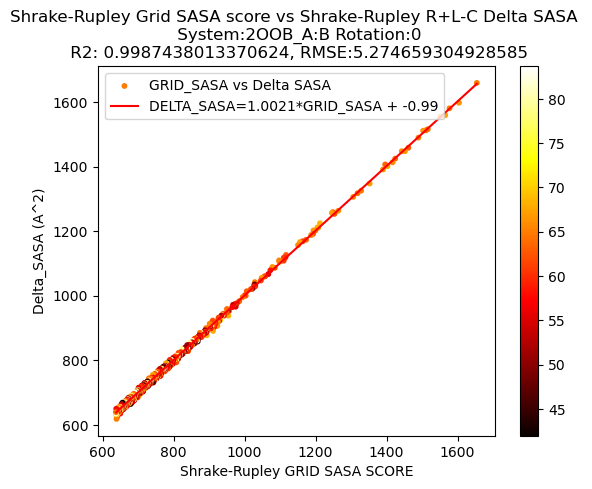

In [61]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
x = np.array(trans_scores)
y = np.array(delta_sasas)
C = np.array(colors)

x = x.reshape((-1,1))
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

pred_y = np.zeros(len(y), dtype=float)
for ind,point in enumerate(x):
    pred_y[ind] = point*model.coef_ + model.intercept_
MSE = mean_squared_error(y, pred_y)
RMSE = math.sqrt(MSE)

# scatter plot
fig, ax = plt.subplots()
# ax.scatter(x, y, 10, c=C, alpha=0.01, marker='o', cmap="hot",
#         label="GRID_SASA vs Delta SASA", edgecolors="black")
sc = ax.scatter(x, y, 10, c=C, alpha=1, marker='o',
        label="GRID_SASA vs Delta SASA", cmap='hot')
# regression plot
rx = np.linspace(x.min(), x.max(), 165)
ry = model.coef_*rx + model.intercept_

ax.plot(rx, ry, '-r', label=f'DELTA_SASA={float(model.coef_):.4f}*GRID_SASA + {float(model.intercept_):.2f}')
plt.xlabel("Shrake-Rupley GRID SASA SCORE")
plt.ylabel("Delta_SASA (A^2)")
ax.set_title(f'Shrake-Rupley Grid SASA score vs Shrake-Rupley R+L-C Delta SASA {chr(10)} System:{system} Rotation:{rot_num}{chr(10)} R2: {r_sq}, RMSE:{RMSE}')
ax.legend(loc='upper left')
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(sc)
# ax.colorbar()
plt.savefig('1A.png')
plt.show()

In [ ]:
for u in range(len(translations)):
    print(score[translations[u]], delta_sasas[u])

In [12]:
com_grid.write_pdb('/home/jtufts/Desktop/test.pdb', "w")
com_grid.write_box('/home/jtufts/Desktop/testbox.pdb')

NATOM:2008


In [134]:
# print(cat_dictionaries(rec_grid._prmtop['POINTERS'], lig_grid._prmtop['POINTERS']))
print(com_grid._get_molecule_sasa(0.14, 960).sum())
print(lig_grid._get_molecule_sasa(0.14, 960).sum())
print(rec_grid._get_molecule_sasa(0.14, 960).sum())
print(rec_grid._get_molecule_sasa(0.14, 960).sum()+lig_grid._get_molecule_sasa(0.14, 960).sum())

7170.8086
3486.3755
4483.7715
7970.147


In [32]:
print(lig_grid._molecule_sasa.sum())

3486.464


In [140]:
import pickle as p
f1 = np.load('/home/jtufts/Desktop/npy/delta_sasa_complex_minus_rl.npy')
f2 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/lig_sasa_sums.p', "rb"))
f3 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/rec_sasa_sums.p', "rb"))
f4 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/lig_sasas.p', "rb"))
f5 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/rec_sasas.p', "rb"))
f6 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/complex_sasas.p', "rb"))
# f4

In [138]:
k2 = list(f2.keys())
k2.sort()
print(k2[127],f2[k2[127]]*100+f3[k2[127]]*100)

2OOB_A:B 7970.235824584961


In [ ]:
lig_grid._move_ligand_to_lower_corner()
ls = lig_grid._get_molecule_sasa(0.14, 960)
rs = rec_grid._get_molecule_sasa(0.14, 960)

for m,val in enumerate(f4[k2[127]][0]):
    print(val,ls[0][m])

In [ ]:
for p,l in enumerate(delta_sasas):
    print(l, f1[127]*100)

In [165]:
(rec_disp - lig_grid._displacement)/0.5

masked_array(data=[68.0, 87.0, 45.0],
             mask=[False, False, False],
       fill_value=1e+20)

In [160]:
rec_disp

masked_array(data=[40.5, 56. , 27. ],
             mask=False,
       fill_value=1e+20)

In [166]:
score[68,87,45]

591.9999999999999

In [167]:
cfft[68,87,45]

(592.0000000000001+2.326614353372607e-13j)

In [48]:
def regplot(trans_scores, delta_sasas, colors, name):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress
    from sklearn.linear_model import LinearRegression

    x = np.array(trans_scores)
    y = np.array(delta_sasas)
    C = np.array(colors, dtype=str)

    change = np.where(C == 'yellow')
    C[change] = "black"

    indicies = np.where(y < 1525)
    # indicies = np.where(y == 0)

    indicies = indicies[::-1]

    for i in indicies:
        x = np.delete(x, i)
        y = np.delete(y, i)
        C = np.delete(C, i)

    indicies = np.where(x == 0)
    indicies = indicies[::-1] 

    for i in indicies:
        x = np.delete(x, i)
        y = np.delete(y, i)
        C = np.delete(C, i)

    x = x.reshape((-1,1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)

    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)


    # scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, 10, c=C, alpha=0.5, marker='+',
            label="SC SCORE vs Delta SASA")
    # regression plot
    rx = np.linspace(x.min(), x.max(), 165)
    ry = model.coef_*rx + model.intercept_

    ax.plot(rx, ry, '-r', label=f'DELTA_SASA={float(model.coef_):.4f}*SC_SCORE + {float(model.intercept_):.2f}')
    plt.xlabel("SC_score")
    plt.ylabel("Delta_SASA (nm^2)")
    ax.set_title(f'R2: {r_sq}')
    ax.legend(loc='upper left')
    plt.savefig(f'{name}')

In [ ]:
for i in range(9):
    # rx,ry,rz = np.random.randint(0, counts[0], 3)
    # rx = np.random.randint(19, 39, 1)
    # ry = np.random.randint(81, 101, 1)
    # rz = np.random.randint(74, 94, 1)
    rx = np.random.randint(26, 32, 1)
    ry = np.random.randint(113, 119, 1)
    rz = np.random.randint(49, 55, 1)
    lgrid_trans = grids.translate_grid(lgrid["SASA"], [rx,ry,rz])
    result = (lgrid_trans*rgrid).sum()
    print((rx,ry,rz), result, cfft[rx,ry,rz], (np.real(result)-np.imag(result)), score[rx,ry,rz])

In [ ]:
for i in range(len(colors)):
    print(i, colors[i])

In [ ]:
rec_grid._prmtop

In [49]:
sasa.sum()

162235.20273234017

In [50]:
lgrid["sasa"].sum()

125989.38912844221

Text(0, 0.5, 'Number of points')

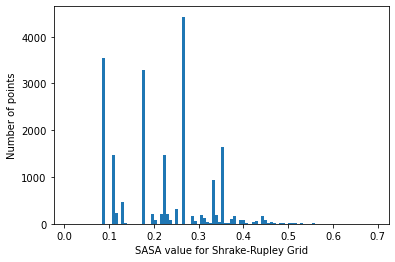

In [36]:
import matplotlib.pyplot as plt

plt.hist(r_grid.flatten(), bins=100, range=(.01, 0.69))
plt.xlabel("SASA value for Shrake-Rupley Grid")
plt.ylabel("Number of points")

In [18]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
print(a)
a = a/5
a

[ 1  2  3  4  5  6  7  8  9 10]


array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [13]:
k = 0

for j in range(10):
    for i in list(range(10))[k:]:
        k = k + 10
        print(i)

0
1
2
3
4
5
6
7
8
9


In [7]:
print(list(range(10)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [40]:
lig_grid._crd.argmin()

2260

In [43]:
np.array([lig_grid._crd[:,i].argmin() for i in range(3)], dtype=int)

array([342, 753,   3])

In [57]:
np.array([lig_grid._crd[:,i].min() for i in range(3)], dtype=float)

array([42.17420387, 31.54957533, 60.36855125])

In [56]:
lig_grid._crd[753]

array([46.4203577 , 31.54957533, 76.50253725])

In [58]:
lig_grid._crd[3]

array([56.34309387, 68.54642868, 60.36855125])

In [63]:
edge_ind = np.array([lig_grid._crd[:,i].argmin() for i in range(3)], dtype=int)
edge_radii = np.array([lig_grid._prmtop["VDW_RADII"][i] for i in edge_ind], dtype=float)
print(edge_radii)

[1.2 1.2 1.2]


In [61]:
lig_grid._prmtop["VDW_RADII"][342]

1.2

In [40]:
lig_grid._displacement

masked_array(data=[-32.5, -42.5, -23. ],
             mask=False,
       fill_value=1e+20)

In [55]:
type(np.array(rec_disp-lig_grid._displacement*lig_grid._spacing))

numpy.ndarray

In [51]:
lig_grid._move_ligand_to_lower_corner()

Ligand translated by [0. 0. 0.]
[2.64105129 2.36711311 2.38056588]


In [52]:
lig_grid._displacement

masked_array(data=[0., 0., 0.],
             mask=False,
       fill_value=1e+20)

In [100]:
sasa.sum()

937691.0

In [17]:
good_grid = nc.Dataset("/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/no_gaussian.nc")
good_sasa = np.array(good_grid.variables["sasa"])
error_grid = nc.Dataset("/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/shrakerupley.nc")
error_sasa = np.array(error_grid.variables["sasa"])

In [18]:
error_sasa.sum()

937691.0

In [19]:
good_sasa.sum()

937691.0

In [21]:
diff = good_sasa - error_sasa

In [22]:
import matplotlib.pyplot as plt

0.0

(0.0, 10.0)

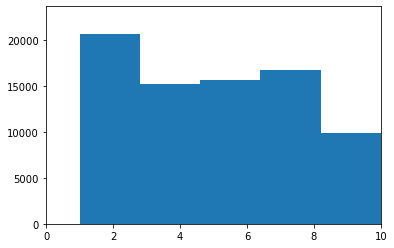

In [47]:
plt.hist(good_ones.flatten(), bins=10)
plt.xlim(0, 10)


(0.0, 10.0)

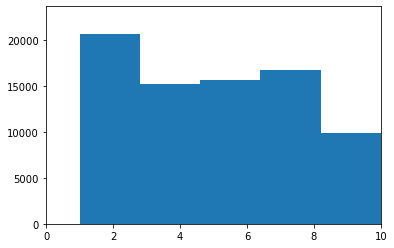

In [46]:
plt.hist(error_ones.flatten(), bins=10)
plt.xlim(0, 10)

In [40]:
good_ones = good_sasa[good_sasa>0]
error_ones = error_sasa[error_sasa>0]

In [41]:
good_ones

array([1., 1., 1., ..., 1., 1., 1.])

In [42]:
error_ones

array([1., 1., 1., ..., 1., 1., 1.])

In [18]:
score.max()

1333.8928316099477

In [20]:
translations*lig_grid._spacing

masked_array(
  data=[[46.5, 45.5, 44.5],
        [46.5, 45.5, 45. ],
        [47. , 45. , 45. ],
        ...,
        [56.5, 76.5, 45.5],
        [43. , 64. , 51.5],
        [39.5, 75.5, 46.5]],
  mask=False,
  fill_value=999999)

In [79]:
complex = md.load("/mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/complex.pdb")
receptor = md.load("/mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/receptor.inpcrd",top="/mnt/fft/FFT_PPI/2.redock/1.amber/2OOB_A:B/receptor.prmtop")
ligand = md.load("/mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd",top="/mnt/fft/FFT_PPI/2.redock/1.amber/2OOB_A:B/ligand.prmtop")
complex_pa_sasa_mdtraj = md.shrake_rupley(complex)

In [ ]:
sasa_diff = 0.0
for i in range(complex_pa_sasa_mdtraj.shape[1]):
    if complex_pa_sasa_mdtraj[0][i]*100-com_pa_sasa[0][i] > 1:
        print(i)
        sasa_diff += (complex_pa_sasa_mdtraj[0][i]*100-com_pa_sasa[0][i])
print(sasa_diff)

In [37]:
com_pa_sasa_nm.sum()

62.464767

In [38]:
complex_pa_sasa_mdtraj.sum()

64.1425

In [81]:
from mdtraj.geometry import _geometry
from mdtraj.geometry.sasa import _ATOMIC_RADII
from bpmfwfft.util import c_sasa
def _get_molecule_sasa(traj, probe_radius, n_sphere_points):
    """
    return the per atom SASA of the target molecule in Angstroms
    probe radius is in nm...
    """
    xyz = traj.xyz
    atom_radii = [_ATOMIC_RADII[atom.element.symbol] for atom in traj.topology.atoms]
    radii = np.array(atom_radii, np.float32) + probe_radius
    dim1 = xyz.shape[1]
    atom_mapping = np.arange(dim1, dtype=np.int32)
    out = np.zeros((xyz.shape[0], dim1), dtype=np.float32)
    _geometry._sasa(xyz, radii, int(n_sphere_points), atom_mapping, out)
    out, centered_sphere_points = c_sasa(xyz, radii, int(n_sphere_points))
    # convert values from nm^2 to A^2
    out = out*100
    return out

In [ ]:
_get_molecule_sasa(complex, 0.14, 960)

In [40]:
complex.xyz

array([[[ 2.0582, -0.9277,  3.9589],
        [ 1.9632, -0.9315,  3.9251],
        [ 2.0634, -0.8532,  4.0276],
        ...,
        [ 0.1103,  0.7235,  0.934 ],
        [ 0.1809,  0.7314,  1.037 ],
        [ 0.0173,  0.641 ,  0.922 ]]], dtype=float32)

In [ ]:
import os
import copy
import numpy as np
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from bpmfwfft.grids import RecGrid, LigGrid
import matplotlib.pyplot as plt
from itertools import cycle

# Constants and paths
PPI_PATH = '/mnt/elpis/jtufts/fft/FFT_PPI_1_0'
HOME = '/home/jtufts'

# Set this to the name of your system (e.g., '1A', '2A', etc.)
SYSTEM_TYPE = '1A'

# Create a directory for plots if it doesn't exist
PLOT_DIR = f'plots_{SYSTEM_TYPE}'
os.makedirs(PLOT_DIR, exist_ok=True)

# Grid parameters
LJ_SIGMA_SCAL_FACT = 1.0
RHO = 9.0
RC_SCALE, RS_SCALE, RM_SCALE = 0.76, 0.53, 0.55
LC_SCALE, LS_SCALE, LM_SCALE = 0.81, 0.50, 0.54

def create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, grid_nc_file):
    return RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, None, grid_nc_file, new_calculation=False)

def create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    return LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)

def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop, grid2._prmtop)
    crd = cat_dictionaries(grid1._crd, grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        for key in dict1_copy.keys():
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy, dict2_copy))

def cat_values(a1, a2):
    array1, array2 = copy.deepcopy(a1), copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1, array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        return array1 + array2
    elif isinstance(array1, list):
        array1.extend(array2)
        return array1

def create_combined_plot(results):
    plt.figure(figsize=(12, 8))
    colors = cycle('bgrcmyk')  # Cycle through these colors for different systems
    
    all_x = []
    all_y = []
    
    for result in results:
        if result['status'] == 'success':
            system = result['system']
            color = next(colors)
            plt.scatter(result['x'], result['y'], alpha=0.3, color=color, label=f'{system}')
            
            all_x.extend(result['x'])
            all_y.extend(result['y'])

    # Perform a single linear regression on all data
    all_x = np.array(all_x).reshape(-1, 1)
    all_y = np.array(all_y)
    
    model = LinearRegression().fit(all_x, all_y)
    r_sq = model.score(all_x, all_y)
    rmse = np.sqrt(mean_squared_error(all_y, model.predict(all_x)))
    
    # Plot the single regression line
    x_range = np.linspace(min(all_x), max(all_x), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    plt.plot(x_range, y_pred, color='red', linestyle='--', label='Combined fit')

    plt.xlabel('Resampled Energy')
    plt.ylabel('Delta SASA')
    plt.title(f'Combined Plot of All {SYSTEM_TYPE} Systems\n' 
              f'R-squared: {r_sq:.4f}, RMSE: {rmse:.4f}\n'
              f'Slope: {model.coef_[0]:.4f}, Intercept: {model.intercept_:.4f}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f'{SYSTEM_TYPE}_combined_plot.png'))
    plt.close()

    return {
        'r_squared': r_sq,
        'rmse': rmse,
        'slope': model.coef_[0],
        'intercept': model.intercept_
    }

def process_system(system):
    try:
        # File paths
        GRID_PATH = f'{PPI_PATH}/2.redock/4.receptor_grid/{system}'
        GRID_NC = f'{GRID_PATH}/grid.nc'
        REC_PRMTOP = f"{PPI_PATH}/2.redock/1.amber/{system}/receptor.prmtop"
        REC_INPCRD = f"{PPI_PATH}/2.redock/2.minimize/{system}/receptor.inpcrd"
        LIG_PRMTOP = f"{PPI_PATH}/2.redock/1.amber/{system}/ligand.prmtop"
        LIG_INPCRD = f"{PPI_PATH}/2.redock/2.minimize/{system}/ligand.inpcrd"
        ROT_NC = f"{PPI_PATH}/2.redock/3.ligand_rand_rot/{system}/rotation.nc"
        FFT_PATH = f'{PPI_PATH}/2.redock/5.fft_sampling/{system}'
        FFT_NC = f'{FFT_PATH}/fft_sample.nc'

        # Check if all required files exist
        for file_path in [GRID_NC, REC_PRMTOP, REC_INPCRD, LIG_PRMTOP, LIG_INPCRD, ROT_NC, FFT_NC]:
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")

        # Create grids
        rec_grid = create_rec_grid(REC_PRMTOP, LJ_SIGMA_SCAL_FACT, RC_SCALE, RS_SCALE, RM_SCALE, RHO, REC_INPCRD, GRID_NC)
        lig_grid = create_lig_grid(LIG_PRMTOP, LJ_SIGMA_SCAL_FACT, LC_SCALE, LS_SCALE, LM_SCALE, LIG_INPCRD, rec_grid)
        
        # Load rotations and translations
        rot_num = 0
        with nc.Dataset(ROT_NC, 'r') as rot_data:
            lig_rot = rot_data.variables['positions']
            lig_grid._crd = np.array(lig_rot[rot_num], dtype=np.float64)
        lig_grid._move_ligand_to_lower_corner()
        
        with nc.Dataset(FFT_NC, 'r') as fft_data:
            resampled_trans_vectors = fft_data.variables["sasa_resampled_trans_vectors"][rot_num][:10]  # Only first 10
            resampled_energies = fft_data.variables["sasa_resampled_energies"][rot_num][:10] / -0.005  # Only first 10
        
        # Calculate SASA for different translations
        delta_sasas = []
        for v, vector in enumerate(resampled_trans_vectors):
            vector = np.array(vector * lig_grid._spacing)
            lig_grid._move_ligand_to_lower_corner()
            lig_grid.translate_ligand(vector)
            com_grid = cat_grids(rec_grid, lig_grid)
            
            c_sasa = com_grid._get_molecule_sasa(0.14, 960).sum()
            l_sasa = lig_grid._get_molecule_sasa(0.14, 960).sum()
            r_sasa = rec_grid._get_molecule_sasa(0.14, 960).sum()
            d_sasa = (l_sasa + r_sasa) - c_sasa
            
            delta_sasas.append(d_sasa)
        
        # Prepare data for analysis
        x = resampled_energies.reshape((-1, 1))
        y = np.array(delta_sasas)
        
        # Linear regression
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rmse = np.sqrt(mean_squared_error(y, model.predict(x)))
        
        # Create individual plot
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, color='blue', alpha=0.5)
        plt.plot(x, model.predict(x), color='red', linewidth=2)
        plt.title(f'System: {system}\nR-squared: {r_sq:.4f}, RMSE: {rmse:.4f}')
        plt.xlabel('Resampled Energy')
        plt.ylabel('Delta SASA')
        plot_file = os.path.join(PLOT_DIR, f'{system}_plot.png')
        plt.savefig(plot_file)
        plt.close()
        
        return {
            'system': system,
            'r_squared': r_sq,
            'rmse': rmse,
            'slope': model.coef_[0],
            'intercept': model.intercept_,
            'status': 'success',
            'plot_file': plot_file,
            'x': x.flatten(),  # Flatten for easier plotting
            'y': y,
            'x_min': x.min(),
            'x_max': x.max()
        }

    except FileNotFoundError as e:
        print(f"Error processing system {system}: {str(e)}")
        return {
            'system': system,
            'status': 'file_not_found',
            'error': str(e)
        }
    except Exception as e:
        print(f"Unexpected error processing system {system}: {str(e)}")
        return {
            'system': system,
            'status': 'error',
            'error': str(e)
        }

def main():
    # Get all system keys
    systems = []
    for dirpath, dirnames, filenames in os.walk(f'{PPI_PATH}/2.redock/2.minimize'):
        if filenames and filenames[0] != 'run_me.sh':
            if 'complex.pdb' in filenames:
                system = dirpath.split('/')[8]
                systems.append(system)
    
    results = []
    for system in systems:
        print(f"Processing system: {system}")
        result = process_system(system)
        results.append(result)
        print(f"Completed: {system}")
    
    # Print summary and create combined plot
    print("\nSummary of Results:")
    successful_results = []
    for result in results:
        print(f"System: {result['system']}")
        if result['status'] == 'success':
            print(f"  Status: Success")
            print(f"  R-squared: {result['r_squared']:.4f}")
            print(f"  RMSE: {result['rmse']:.4f}")
            print(f"  Slope: {result['slope']:.4f}")
            print(f"  Intercept: {result['intercept']:.4f}")
            print(f"  Plot saved as: {result['plot_file']}")
            successful_results.append(result)
        else:
            print(f"  Status: {result['status']}")
            print(f"  Error: {result['error']}")
        print()

     # Create combined plot
    if successful_results:
        combined_stats = create_combined_plot(successful_results)
        print(f"Combined plot saved as: {os.path.join(PLOT_DIR, f'{SYSTEM_TYPE}_combined_plot.png')}")
        print(f"Combined R-squared: {combined_stats['r_squared']:.4f}")
        print(f"Combined RMSE: {combined_stats['rmse']:.4f}")
        print(f"Combined Slope: {combined_stats['slope']:.4f}")
        print(f"Combined Intercept: {combined_stats['intercept']:.4f}")
    else:
        print("No successful results to create combined plot.")

    # Print statistics
    total_systems = len(results)
    successful_systems = len(successful_results)
    failed_systems = total_systems - successful_systems
    print(f"Total systems processed: {total_systems}")
    print(f"Successful: {successful_systems}")
    print(f"Failed: {failed_systems}")

if __name__ == "__main__":
    main()

In [77]:
results

NameError: name 'results' is not defined

In [72]:
systems = []
for dirpath, dirnames, filenames in os.walk(f'{PPI_PATH}/2.redock/2.minimize'):
    if filenames and filenames[0] != 'run_me.sh':
        if 'complex.pdb' in filenames:
            system = dirpath.split('/')[8]
            systems.append(system)

In [18]:
%load_ext cython

In [26]:
%%cython --cplus
# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False
# cython: cdivision=True

cdef extern from "math.h":
    double sqrt(double)
    double cos(double)
    double sin(double)
    double fmod(double x, double y)
    double M_PI

from cython.parallel cimport prange, parallel
from libcpp.vector cimport vector
cimport openmp

import numpy as np
cimport cython
import numpy as np
cimport numpy as np
import math
from cython cimport view
from scipy.optimize import nnls

cdef struct NeighborInfo:
    Py_ssize_t index
    double radius_squared

def c_asa_frame(double[:, ::1] crd,
                double[::1] atom_radii,
                double[::1] spacing,
                double[:, ::1] sphere_points,
                int n_sphere_points,
                int natoms_i,
                int atomind):

    cdef:
        Py_ssize_t i, j, k, dim
        int natoms = crd.shape[0]
        double atom_radius_i, r2
        bint is_accessible
        double[:, :, ::1] accessible_sphere_points = np.zeros((natoms_i, n_sphere_points, 4), dtype=np.float64)
        vector[vector[NeighborInfo]] all_neighbors = vector[vector[NeighborInfo]](natoms_i)
        double[:, :, ::1] centered_sphere_points = np.zeros((natoms_i, n_sphere_points, 3), dtype=np.float64)

    # Pre-compute neighbor information and centered sphere points
    for i in range(natoms_i):
        atom_radius_i = atom_radii[i + atomind]
        for j in range(natoms):
            if i + atomind == j:
                continue

            r2 = 0
            for dim in range(3):
                r2 += (crd[i + atomind, dim] - crd[j, dim]) ** 2

            if r2 < (atom_radius_i + atom_radii[j]) ** 2:
                neighbor = NeighborInfo(j, atom_radii[j] ** 2)
                all_neighbors[i].push_back(neighbor)

        for j in range(n_sphere_points):
            for dim in range(3):
                centered_sphere_points[i, j, dim] = crd[i + atomind, dim] + atom_radius_i * sphere_points[j, dim]

    # Parallel accessibility check
    with nogil, parallel():
        cdef vector[NeighborInfo] neighbors
        cdef NeighborInfo neighbor
        for i in prange(natoms_i, schedule='dynamic'):
            neighbors = all_neighbors[i]
            for j in range(n_sphere_points):
                is_accessible = True
                for k in range(neighbors.size()):
                    neighbor = neighbors[k]
                    r2 = 0
                    for dim in range(3):
                        r2 += (centered_sphere_points[i, j, dim] - crd[neighbor.index, dim]) ** 2
                    if r2 < neighbor.radius_squared:
                        is_accessible = False
                        break

                if is_accessible:
                    for dim in range(3):
                        accessible_sphere_points[i, j, dim] = centered_sphere_points[i, j, dim]
                    accessible_sphere_points[i, j, 3] = atom_radii[i + atomind]

    return np.asarray(accessible_sphere_points)

@cython.boundscheck(False)
def c_generate_sphere_points(int n_points):
    cdef:
        int i
        float y, r, phi
        float inc = M_PI * (3.0 - sqrt(5.0))
        float offset = 2.0 / n_points
        np.ndarray[np.float64_t, ndim = 2] sphere_points = np.empty([n_points, 3], dtype=np.float64)

    for i in range(n_points):
        y = i * offset - 1.0 + (offset / 2.0)
        r = sqrt(1.0 - y*y)
        phi = i * inc

        sphere_points[i, 0] = cos(phi) * r
        sphere_points[i, 1] = y
        sphere_points[i, 2] = sin(phi) * r
    return sphere_points


@cython.boundscheck(False)
def c_sasa(         np.ndarray[np.float64_t, ndim=2] crd,
                    np.ndarray[np.float64_t, ndim=1] atom_radii,
                    np.ndarray[np.float64_t, ndim=1] spacing,
                    float probe_size,
                    int n_sphere_points,
                    int natoms_i,
                    int atomind
                    ):
    cdef:
        int natoms = crd.shape[0]
        int i, j
        np.ndarray[np.float64_t, ndim = 2] sphere_points = np.empty([n_sphere_points, 3], dtype=np.float64)
        np.ndarray[np.float64_t, ndim = 3] accessible_sphere_points = np.zeros([natoms_i, n_sphere_points, 4], dtype=np.float64)
    sphere_points = c_generate_sphere_points(n_sphere_points)
    accessible_sphere_points = c_asa_frame(crd, atom_radii+probe_size, spacing, sphere_points, n_sphere_points, natoms_i, atomind)

    return accessible_sphere_points


Error compiling Cython file:
------------------------------------------------------------
...
            for dim in range(3):
                centered_sphere_points[i, j, dim] = crd[i + atomind, dim] + atom_radius_i * sphere_points[j, dim]

    # Parallel accessibility check
    with nogil, parallel():
        cdef vector[NeighborInfo] neighbors
             ^
------------------------------------------------------------

/home/jtufts/.cache/ipython/cython/_cython_magic_4362fb458f2b9b2efab919dcc83fe5f23c2fe6ab.pyx:67:13: cdef statement not allowed here


In [14]:
%%time
from bpmfwfft.util import c_sasa, c_points_to_grid
points = c_sasa(lig_grid._crd, lig_grid._prmtop["VDW_RADII"], lig_grid._spacing, 1.4, 960, lig_grid._crd.shape[0], 0)
grid = c_points_to_grid(points, lig_grid._spacing, lig_grid._grid["counts"])

CPU times: user 6.3 s, sys: 248 ms, total: 6.54 s
Wall time: 6.32 s


In [ ]:
%%time
lig_grid._get_molecule_sasa(1.4,960)

In [ ]:
np.save("crd.npy", lig_grid._crd)
np.save("atomradii.npy", lig_grid._prmtop["VDW_RADII"], 